In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.linear_model import LassoCV
import json


## 数据处理部分

In [13]:
data = pd.read_pickle("data/data_processed_all_unscaled.pkl")
X_orig = data.drop(columns=['Purpose of visit to CITY', 'Number of nights in CITY']).to_numpy()
y = data['Number of nights in CITY'].to_numpy()

In [14]:
ss = np.load('data/outliers_unscaled.npz')
outliers = ss['outliers'].astype(int)
rows_to_remove = outliers
X_orig = np.delete(X_orig, rows_to_remove, axis=0)
y = np.delete(y, rows_to_remove)
print(rows_to_remove.shape)

# ss = np.load('data/outliers_scaled.npz')
# outliers = ss['outliers'].astype(int)
# rows_to_remove = outliers
# X_orig = np.delete(X_orig, rows_to_remove, axis=0)
# y = np.delete(y, rows_to_remove)



(9,)


In [15]:
pca_50 = PCA(n_components= 50)  
X_pca_50 = pca_50.fit_transform(X_orig)

pca_100 = PCA(n_components= 100)  
X_pca_100 = pca_100.fit_transform(X_orig)

pca_200 = PCA(n_components= 200)  
X_pca_200 = pca_200.fit_transform(X_orig)

In [5]:
select_50 = SelectKBest(score_func=f_regression, k=50)
X_selected_50 = select_50.fit_transform(X_orig, y)

select_100 = SelectKBest(score_func=f_regression, k=100)
X_selected_100 = select_100.fit_transform(X_orig, y)

select_200 = SelectKBest(score_func=f_regression, k=200)
X_selected_200 = select_200.fit_transform(X_orig, y)

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
def visualization_subplot(ax, y_pred, y_reg_test, row_title):
    residuals = y_reg_test - y_pred
    abs_residuals = np.abs(residuals)

    if row_title == "Actual vs Predicted":
        ax.scatter(y_reg_test, y_pred, color='blue', alpha=0.6)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
    elif row_title == "Residuals vs Predicted":
        ax.scatter(y_pred, abs_residuals, color='green', alpha=0.7)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Residuals')
    elif row_title == "Residual Distribution":
        ax.hist(residuals, bins=20, color='purple', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Residuals')
        ax.set_ylabel('Frequency')
    
    ax.grid(True)

row_titles = ["Actual vs Predicted", "Residuals vs Predicted", "Residual Distribution"]

In [8]:
feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

## Linear Regression

Linear Regression - Fold 0  - MSE: 536.0919, MAE: 7.8978, R2: -0.5260
Linear Regression - Fold 1  - MSE: 263.6998, MAE: 5.9405, R2: 0.2875
Linear Regression - Fold 2  - MSE: 407.2734, MAE: 6.5039, R2: 0.1343
Linear Regression - Fold 3  - MSE: 369.0168, MAE: 6.9336, R2: 0.3102
Linear Regression - Fold 4  - MSE: 231.4934, MAE: 5.8802, R2: 0.2828


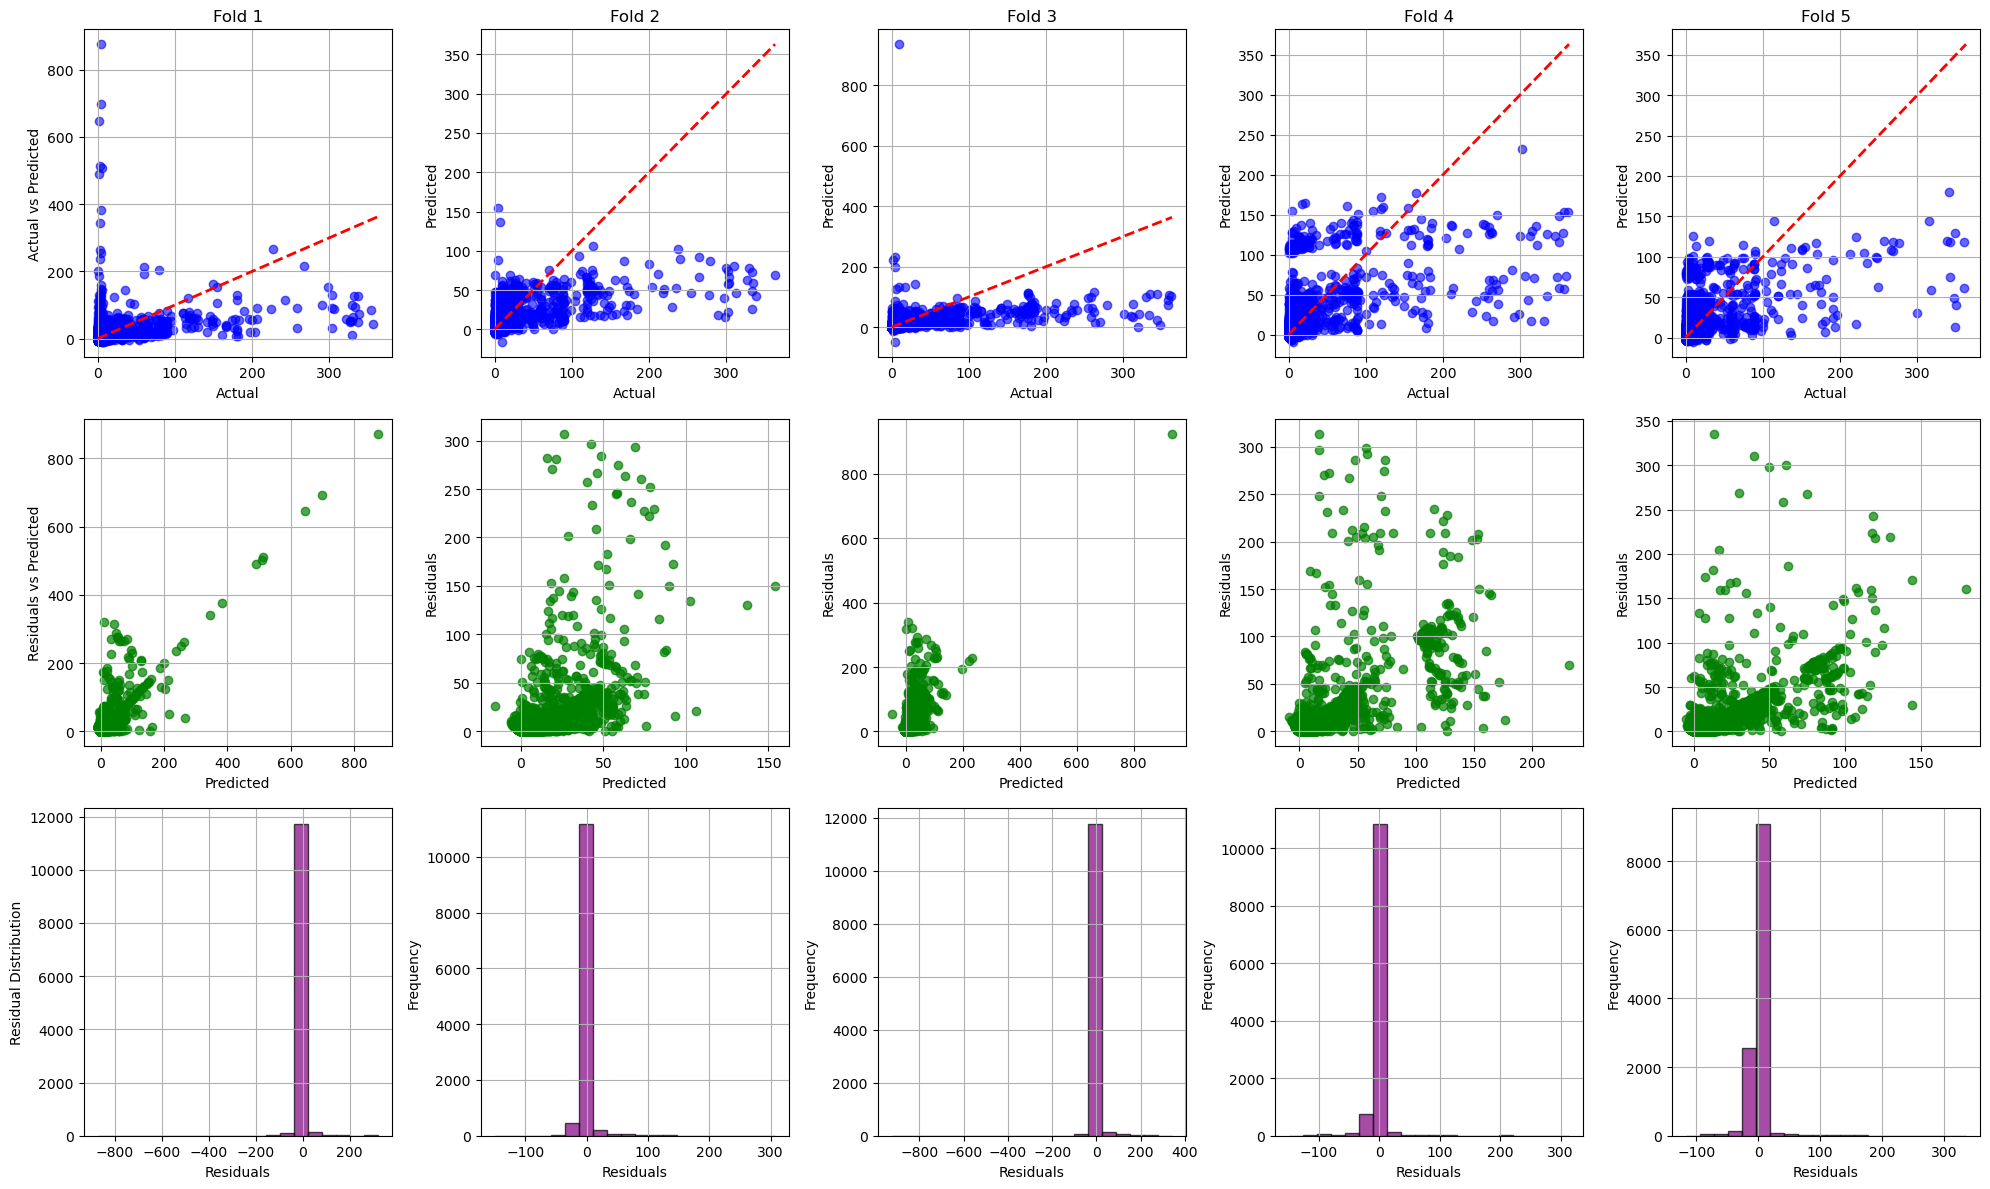

In [97]:
name = 'Linear Regression'

X = feature_sets['Scaled_Select50Best']

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    model = LinearRegression(n_jobs=20)
    model.fit(X_train, y_reg_train)

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    print(f'{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

plt.tight_layout()
plt.show()

## Polynomial Regression

Polynomial Regression - Fold 0  - MSE: 159.1543, MAE: 4.4537, R2: -0.0090
Polynomial Regression - Fold 1  - MSE: 104.1517, MAE: 3.6563, R2: 0.0446
Polynomial Regression - Fold 2  - MSE: 120.3105, MAE: 3.5662, R2: 0.1094
Polynomial Regression - Fold 3  - MSE: 159.7833, MAE: 3.6893, R2: 0.0418
Polynomial Regression - Fold 4  - MSE: 29.0937, MAE: 1.4521, R2: 0.1095


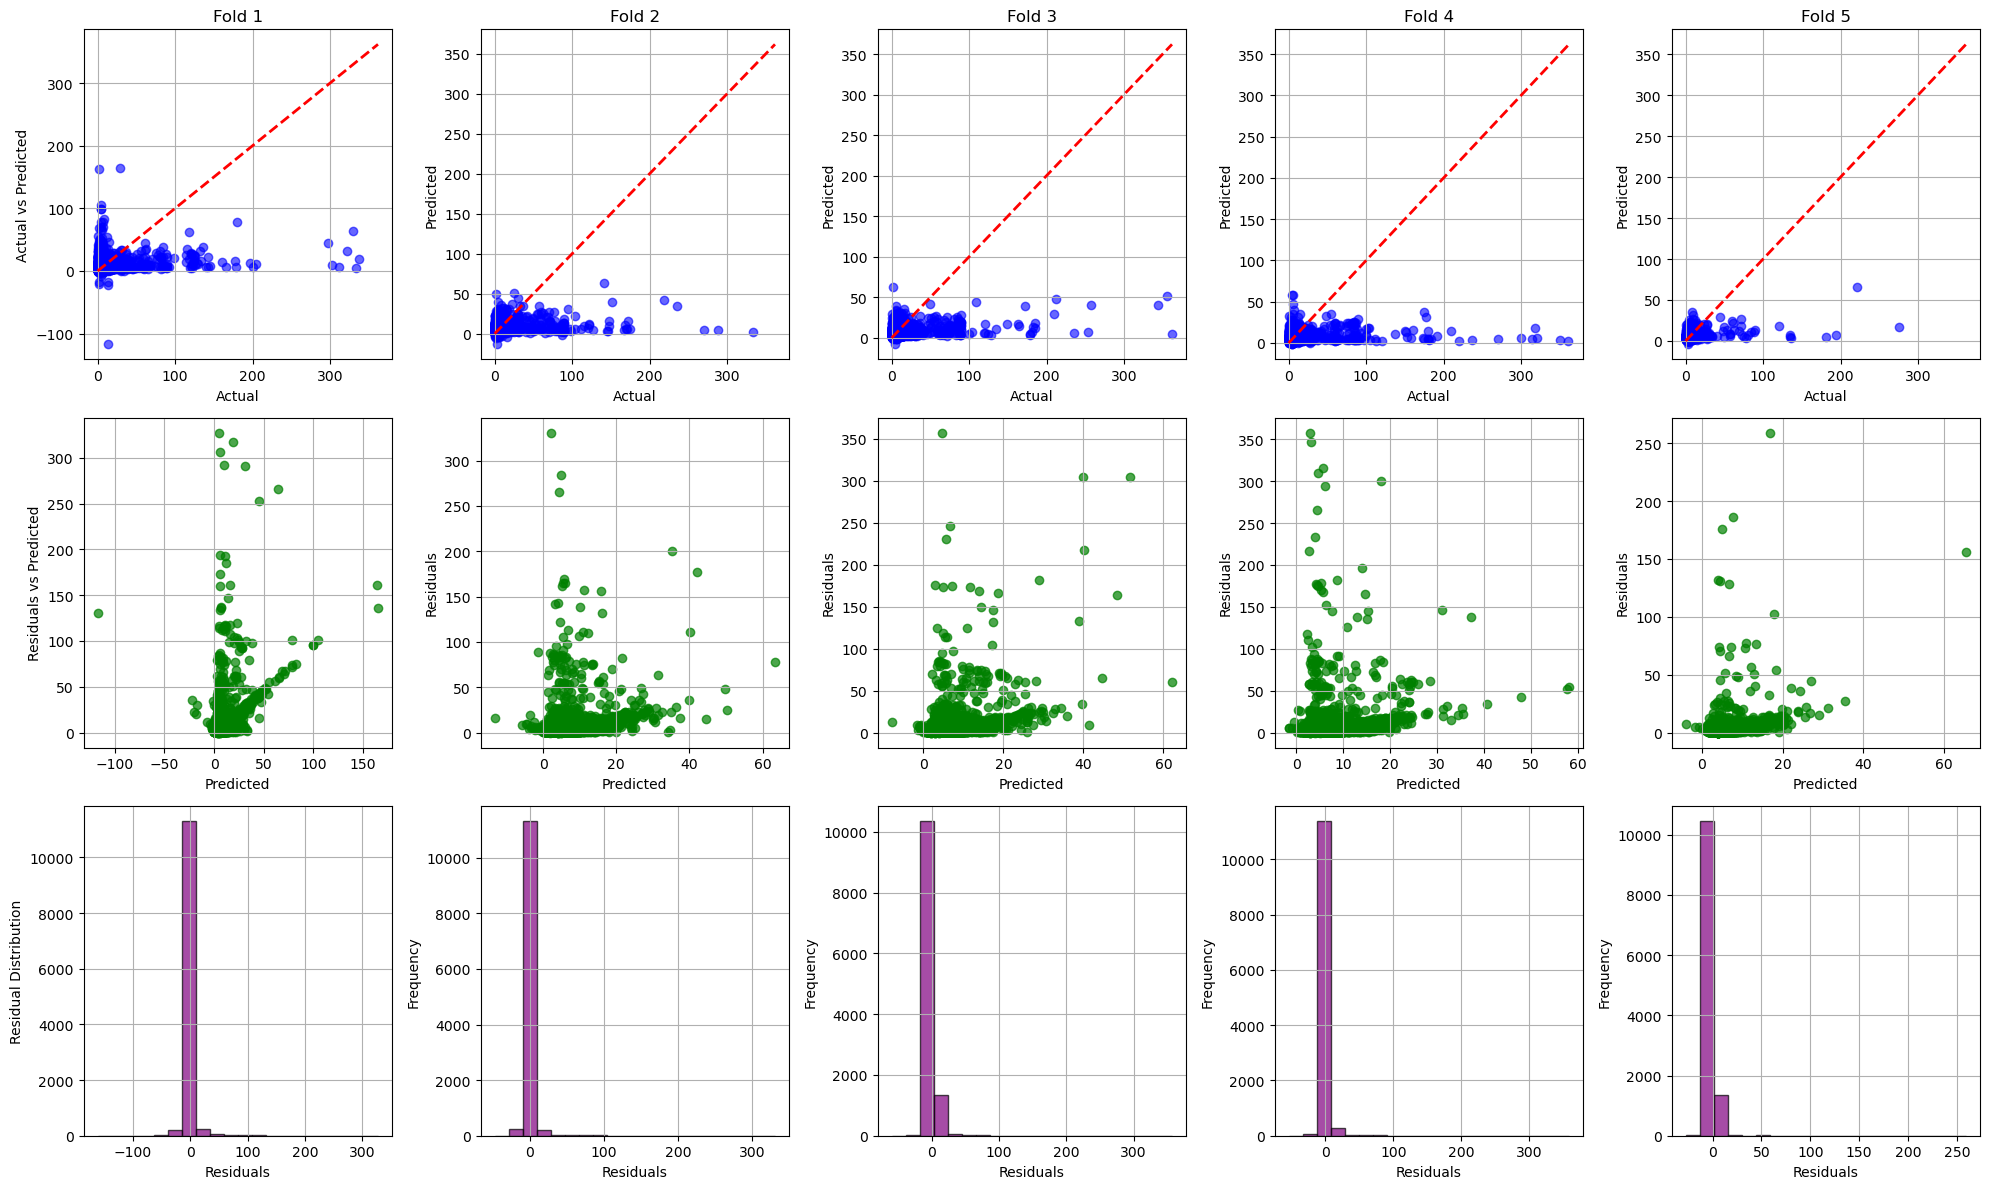

In [88]:
name = 'Polynomial Regression'
degree = 2

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

X = feature_sets['Select100Best']

x = X[:, :11]
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(x)
X_poly = np.hstack((X_poly, X[:, 11:]))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_poly)):
    X_train, X_test = X_poly[train_idx], X_poly[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
    model = LinearRegression(n_jobs=20)
    model.fit(X_train, y_reg_train)

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    print(f'{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')
    
    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

plt.tight_layout()
plt.show()
        

## Ridge

d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.49403e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.45062e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge - Fold 0  - MSE: 536.1183, MAE: 7.8977, R2: -0.5260
Ridge - Fold 1  - MSE: 263.7007, MAE: 5.9405, R2: 0.2875
Ridge - Fold 2  - MSE: 420.6219, MAE: 6.5518, R2: 0.1060
Ridge - Fold 3  - MSE: 355.5818, MAE: 6.8081, R2: 0.3353
Ridge - Fold 4  - MSE: 229.1816, MAE: 5.8696, R2: 0.2900


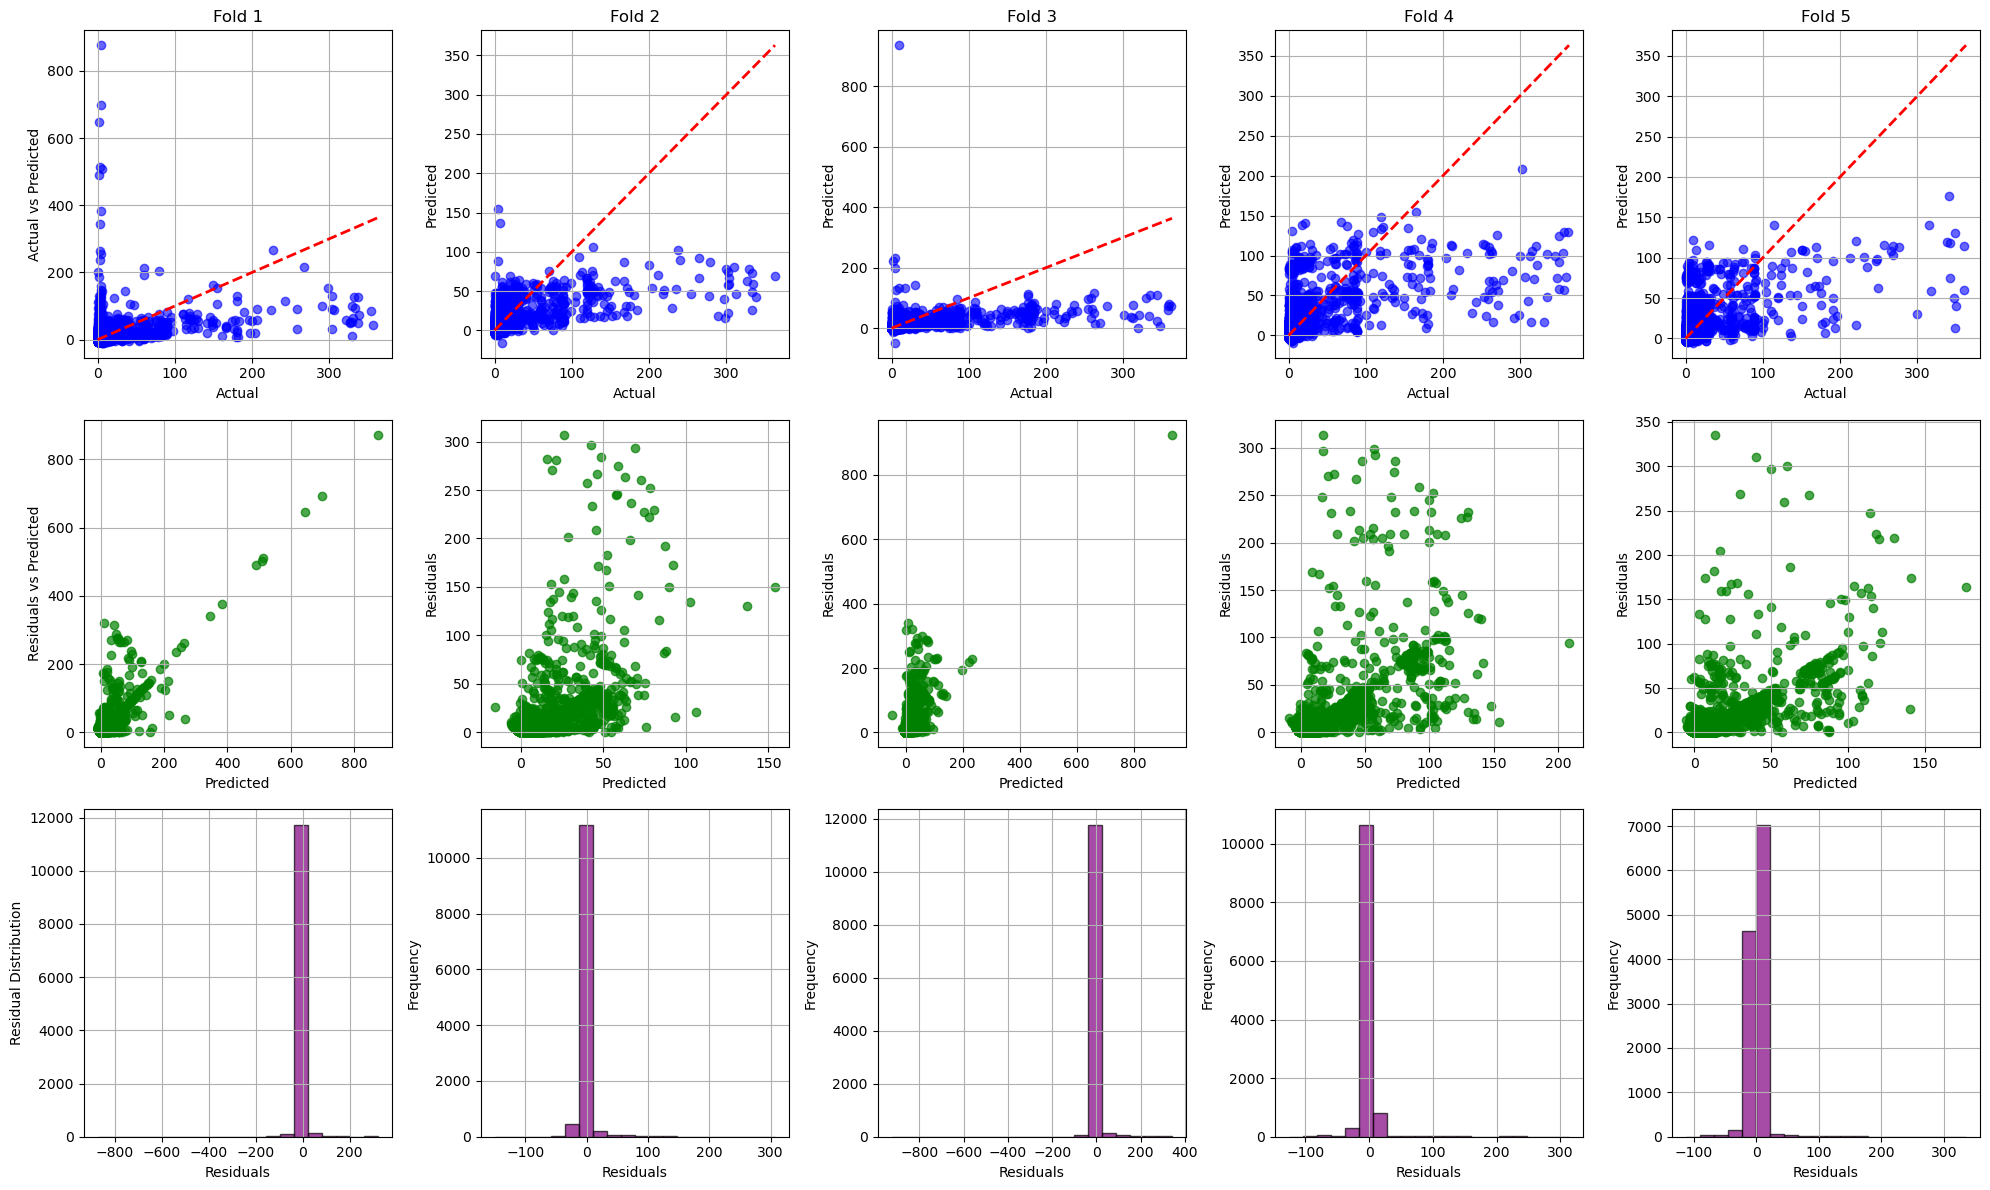

In [98]:
ridge_params = {
    'alpha': [0.1, 1, 10, 100]
    }
name = 'Ridge'

X = feature_sets['Select50Best']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    # Train the model with GridSearchCV
    model = Ridge(solver='auto')
    grid = GridSearchCV(model, ridge_params, cv=3, scoring='neg_mean_squared_error', n_jobs=16)
    grid.fit(X_train, y_reg_train)
    model = grid.best_estimator_

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## Lasso

Lasso - Fold 0  - MSE: 155.1289, MAE: 3.8045, R2: 0.0166
Lasso - Fold 1  - MSE: 104.8931, MAE: 3.4329, R2: 0.0378
Lasso - Fold 2  - MSE: 128.1986, MAE: 3.4357, R2: 0.0510
Lasso - Fold 3  - MSE: 162.5508, MAE: 3.6010, R2: 0.0252
Lasso - Fold 4  - MSE: 30.5314, MAE: 1.3455, R2: 0.0655


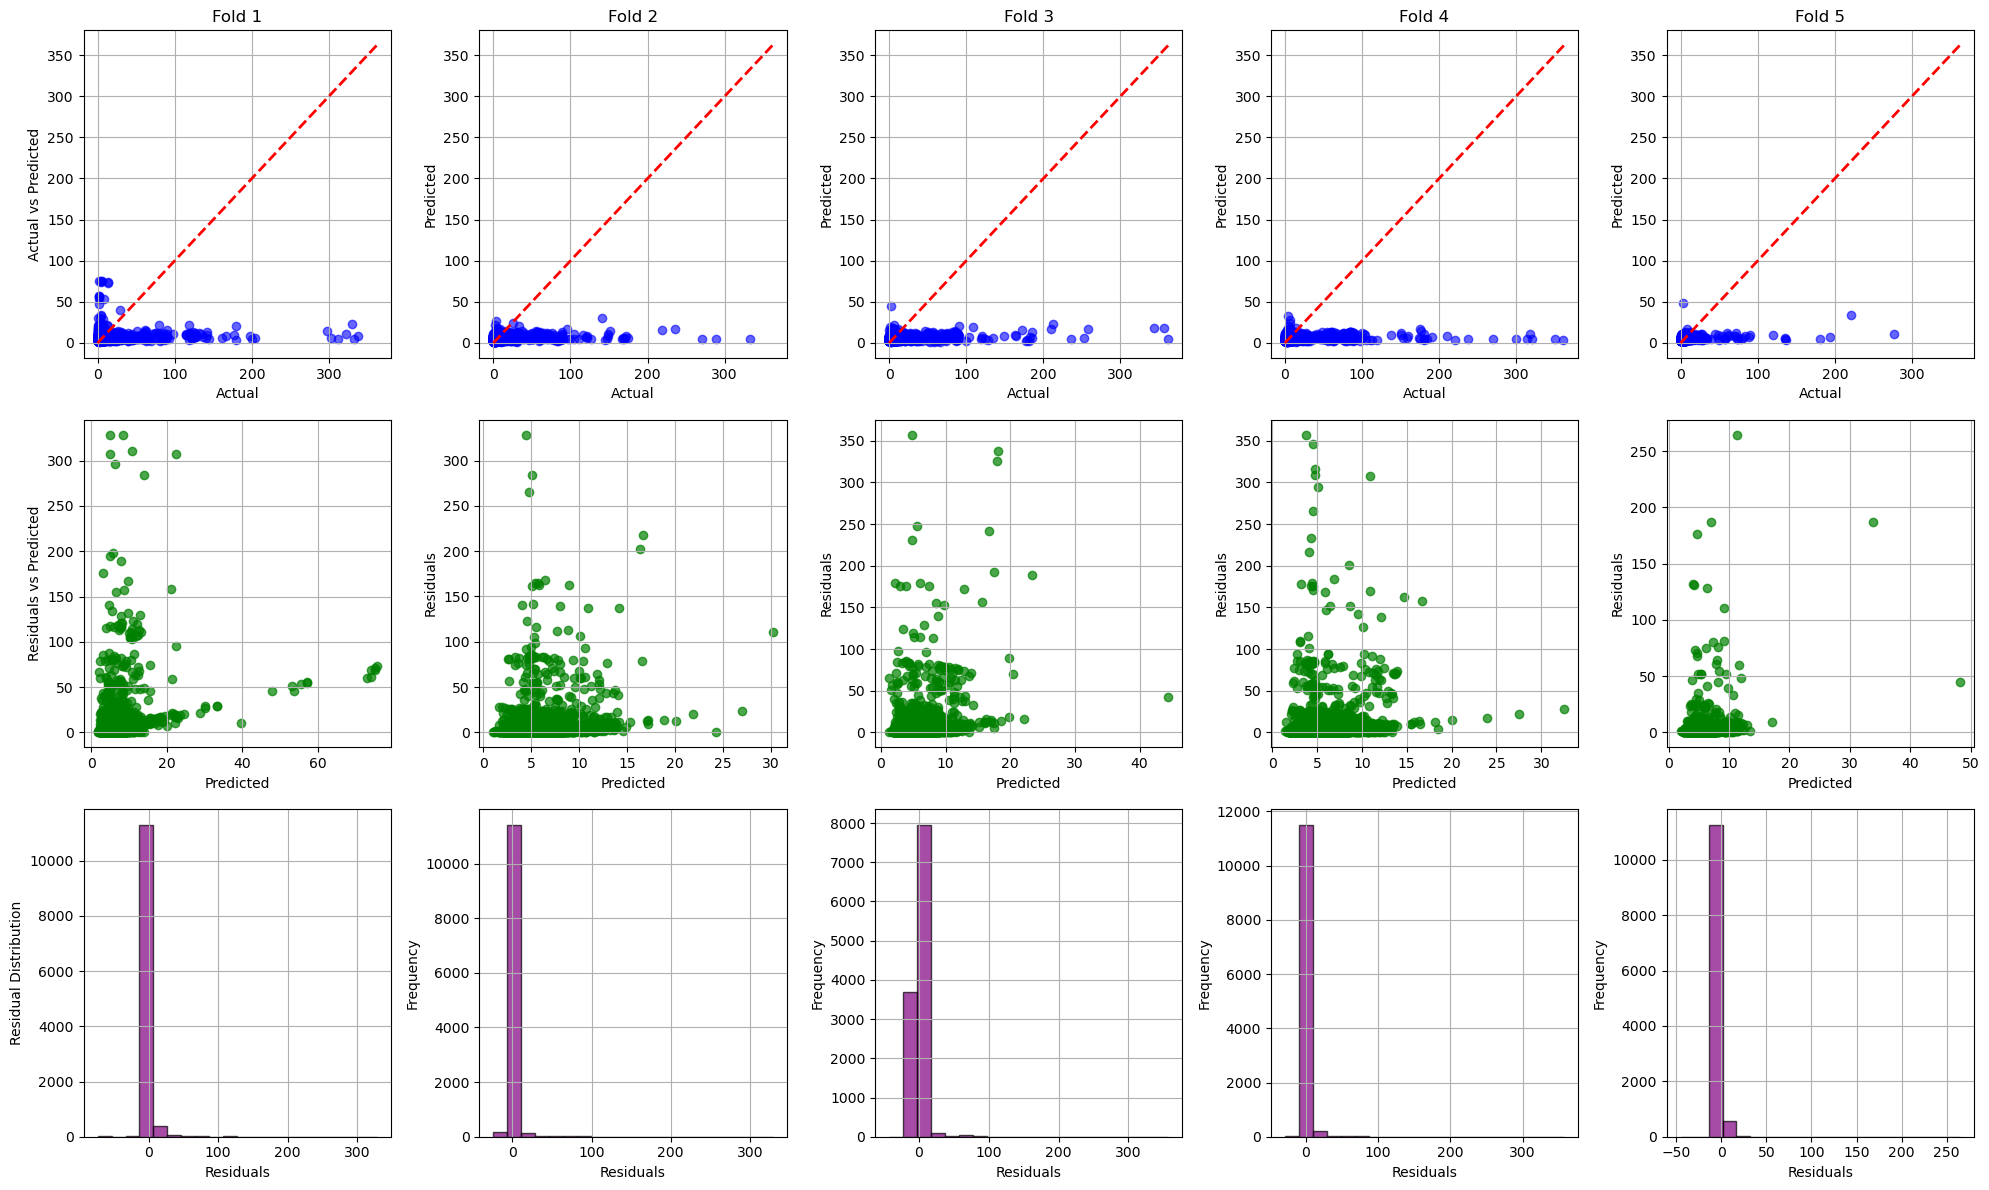

In [87]:
name = "Lasso"

X = feature_sets['Scaled_PCA_200']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    # Train the model with GridSearchCV
    model = LassoCV(cv=5, max_iter=10000, n_jobs=20, random_state=42)
    model.fit(X_train, y_reg_train)

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## Decision Tree

Decision Tree - Fold 0  - MSE: 159.4121, MAE: 2.0461, R2: 0.5462
Decision Tree - Fold 1  - MSE: 51.5997, MAE: 0.6477, R2: 0.8606
Decision Tree - Fold 2  - MSE: 161.0038, MAE: 1.8281, R2: 0.6578
Decision Tree - Fold 3  - MSE: 132.2401, MAE: 1.3605, R2: 0.7528
Decision Tree - Fold 4  - MSE: 163.9820, MAE: 1.5120, R2: 0.4920


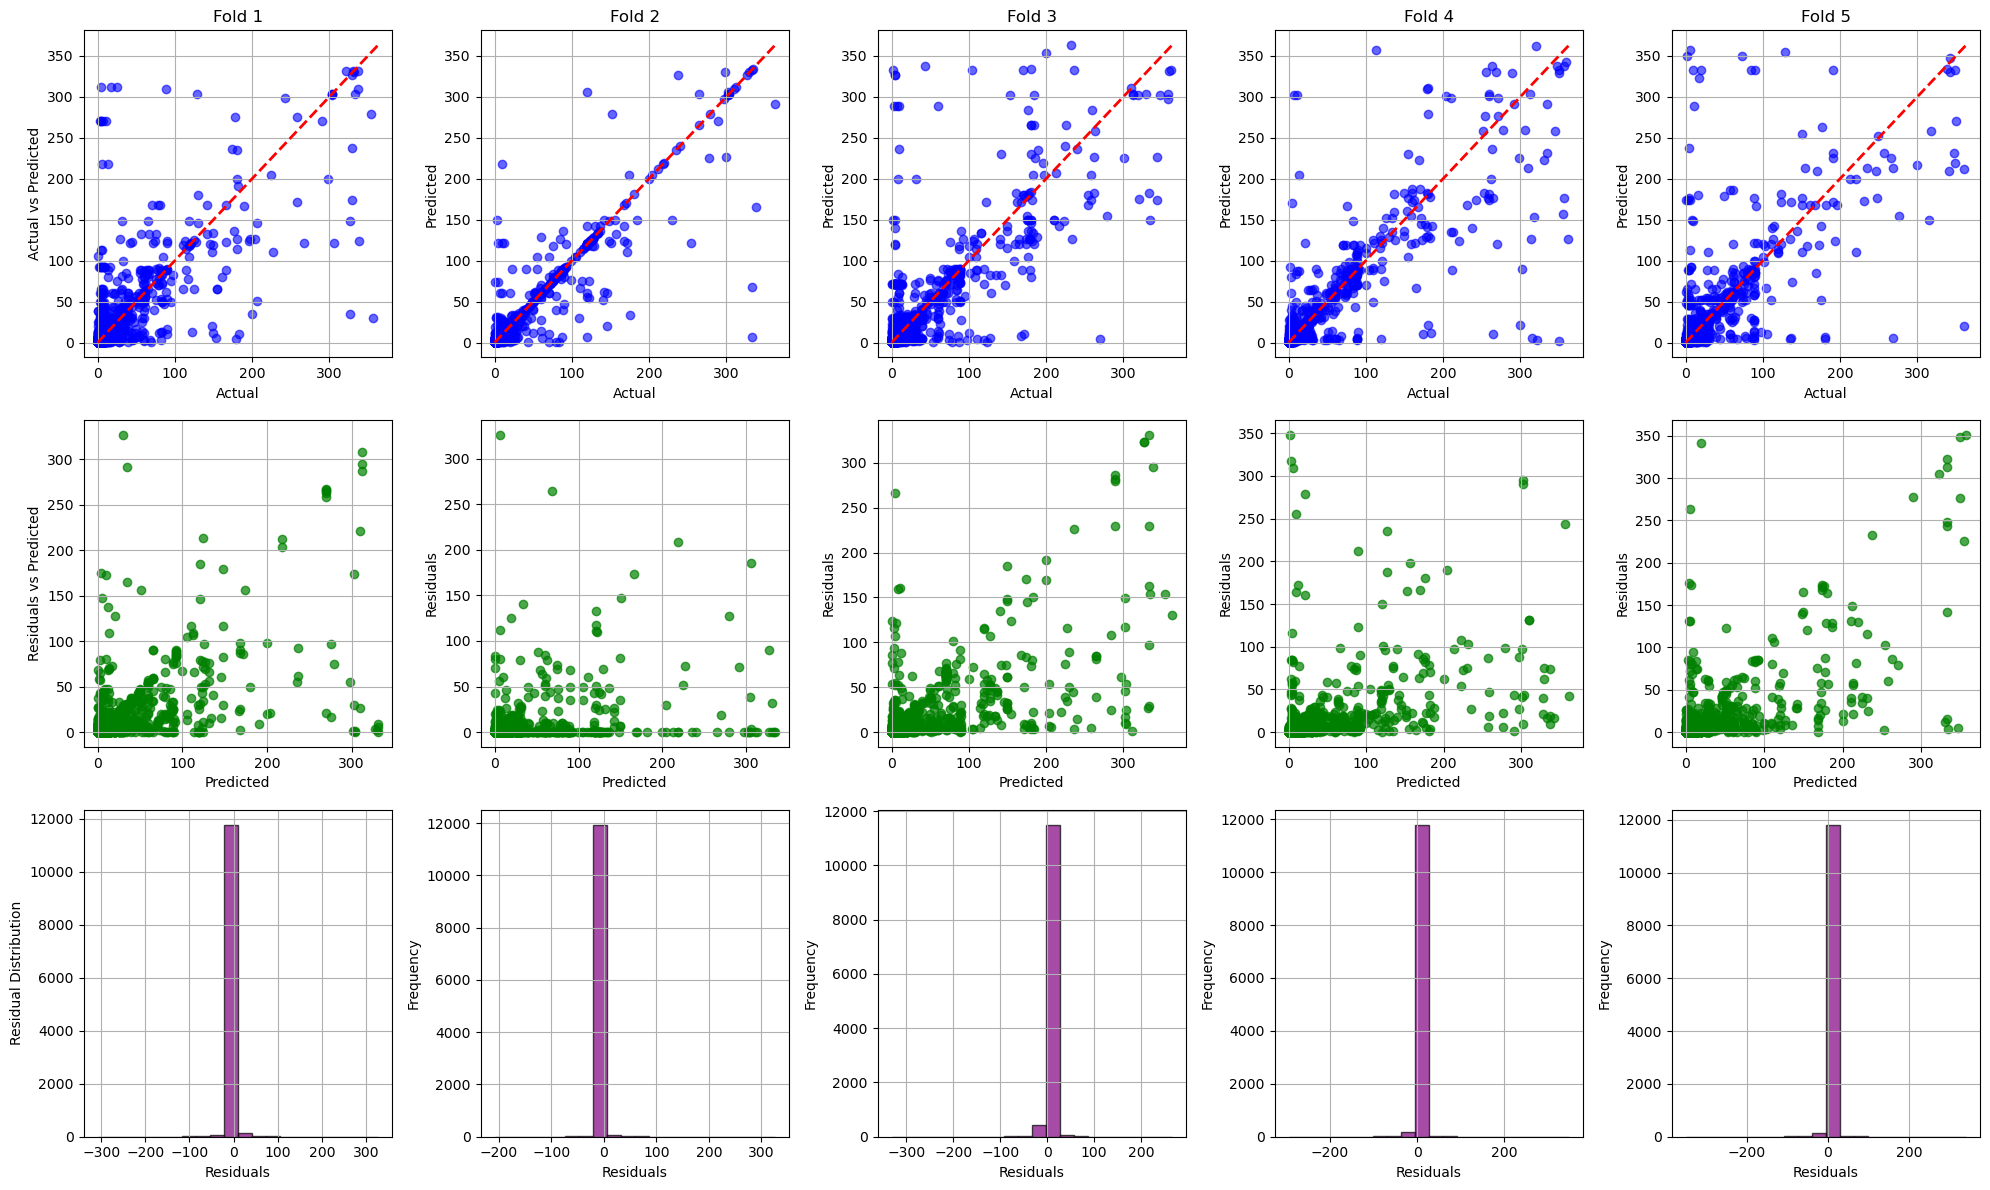

In [99]:
Decision_Tree_params = {
    'max_depth': [100, 200, 500]
    }
name = 'Decision Tree'

X = feature_sets['Scaled_Select200Best']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    # Train the model with GridSearchCV
    model = DecisionTreeRegressor()
    grid = GridSearchCV(model, Decision_Tree_params, cv=3, scoring='neg_mean_squared_error', n_jobs=20)
    grid.fit(X_train, y_reg_train)
    model = grid.best_estimator_

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()

## SVR 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]SVR - Fold 0  - MSE: 347.4865, MAE: 3.9412, R2: 0.0109
SVR - Fold 1  - MSE: 363.1513, MAE: 3.9687, R2: 0.0188
SVR - Fold 2  - MSE: 463.7482, MAE: 4.4953, R2: 0.0143
SVR - Fold 3  - MSE: 525.4893, MAE: 4.5030, R2: 0.0177
SVR - Fold 4  - MSE: 313.1176, MAE: 3.6385, R2: 0.0299


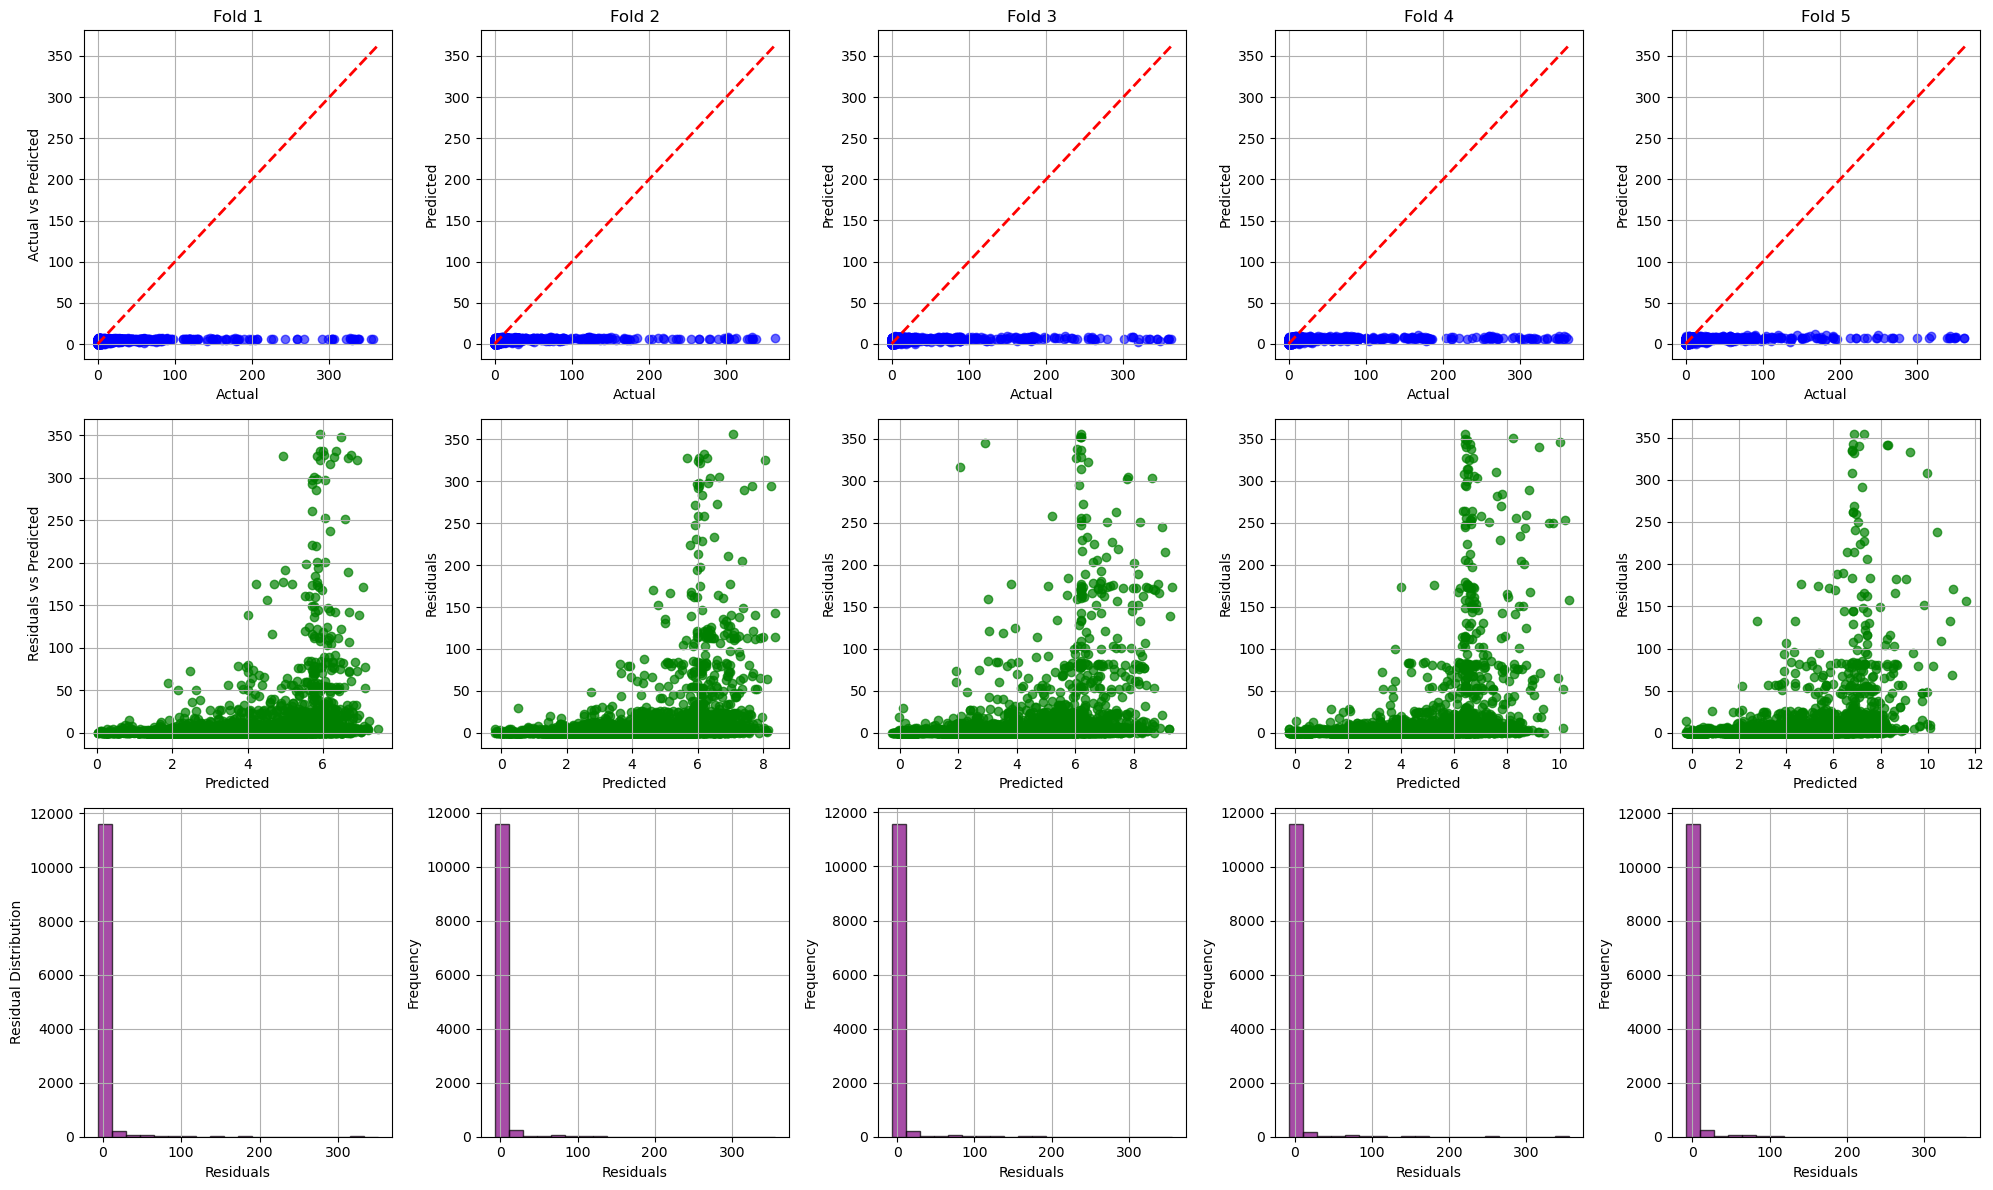

In [100]:
name = 'SVR'

X = feature_sets['Scaled_Select50Best']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    # Train the model with GridSearchCV
    model = SVR(verbose=1, C=0.1, kernel="rbf", tol=1e-2)
    model.fit(X_train, y_reg_train)

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()

# 集成算法

## Random Forest

Random Forest - Fold 0  - MSE: 94.4998, MAE: 2.0981, R2: 0.7310
Random Forest - Fold 1  - MSE: 38.8500, MAE: 0.7109, R2: 0.8950
Random Forest - Fold 2  - MSE: 57.8378, MAE: 1.2328, R2: 0.8771
Random Forest - Fold 3  - MSE: 88.7531, MAE: 1.0394, R2: 0.8341
Random Forest - Fold 4  - MSE: 52.3904, MAE: 1.0410, R2: 0.8377


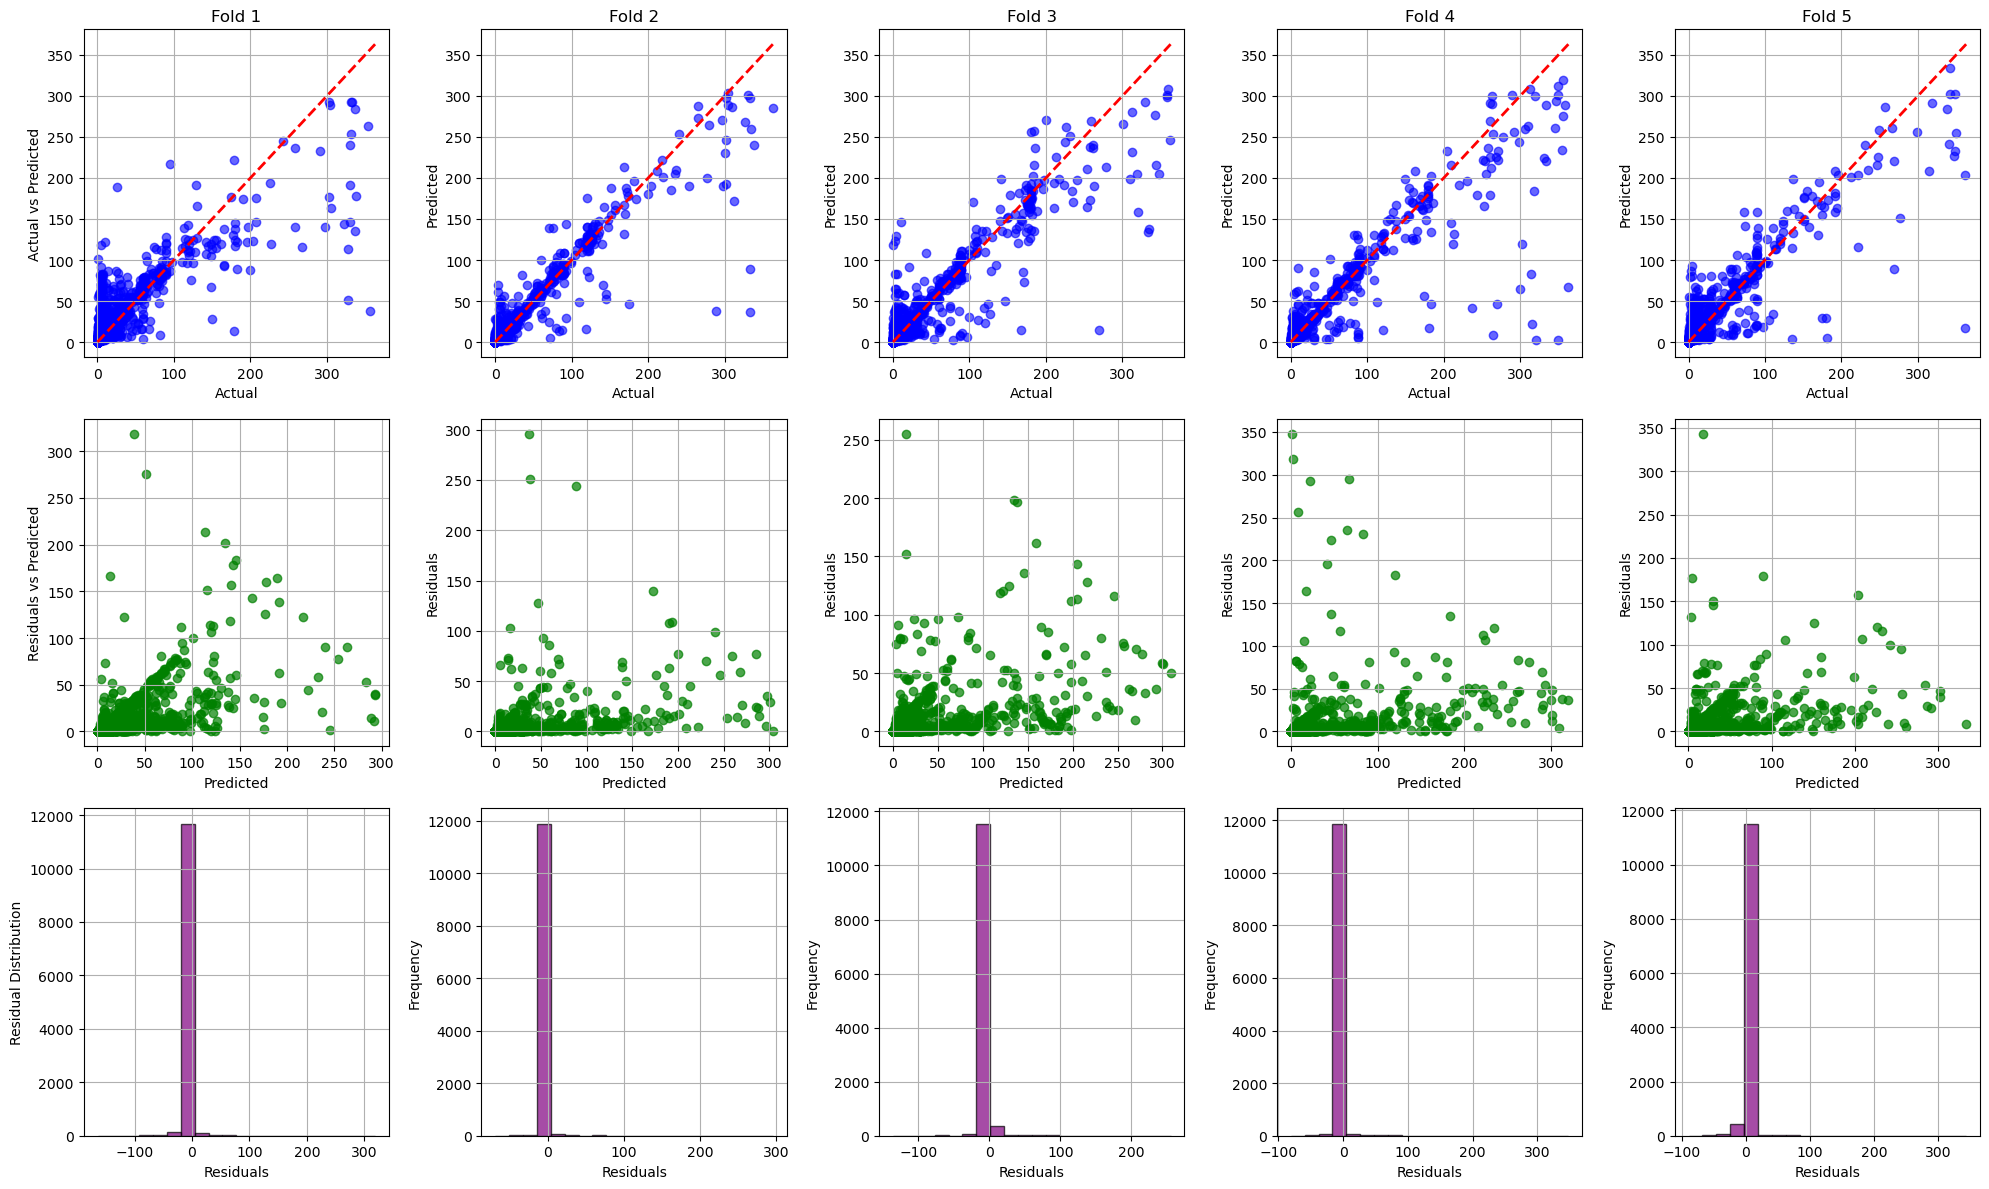

In [9]:
rf_params = {
    'n_estimators': [50, 100], 
    'max_depth': [50, 100, 200]
    }
name = 'Random Forest'

X = feature_sets['Original']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    # Train the model with GridSearchCV
    model = RandomForestRegressor(n_estimators=50, n_jobs=10)
    grid = GridSearchCV(model, rf_params, cv=2, n_jobs=10)
    grid.fit(X_train, y_reg_train)
    model = grid.best_estimator_

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()



## Bagging Method

Bagging - Fold 0  - MSE: 108.1098, MAE: 2.2712, R2: 0.6923
Bagging - Fold 1  - MSE: 30.9898, MAE: 0.6446, R2: 0.9163
Bagging - Fold 2  - MSE: 61.0353, MAE: 1.2183, R2: 0.8703
Bagging - Fold 3  - MSE: 92.9547, MAE: 1.1271, R2: 0.8262
Bagging - Fold 4  - MSE: 62.9729, MAE: 1.1010, R2: 0.8049


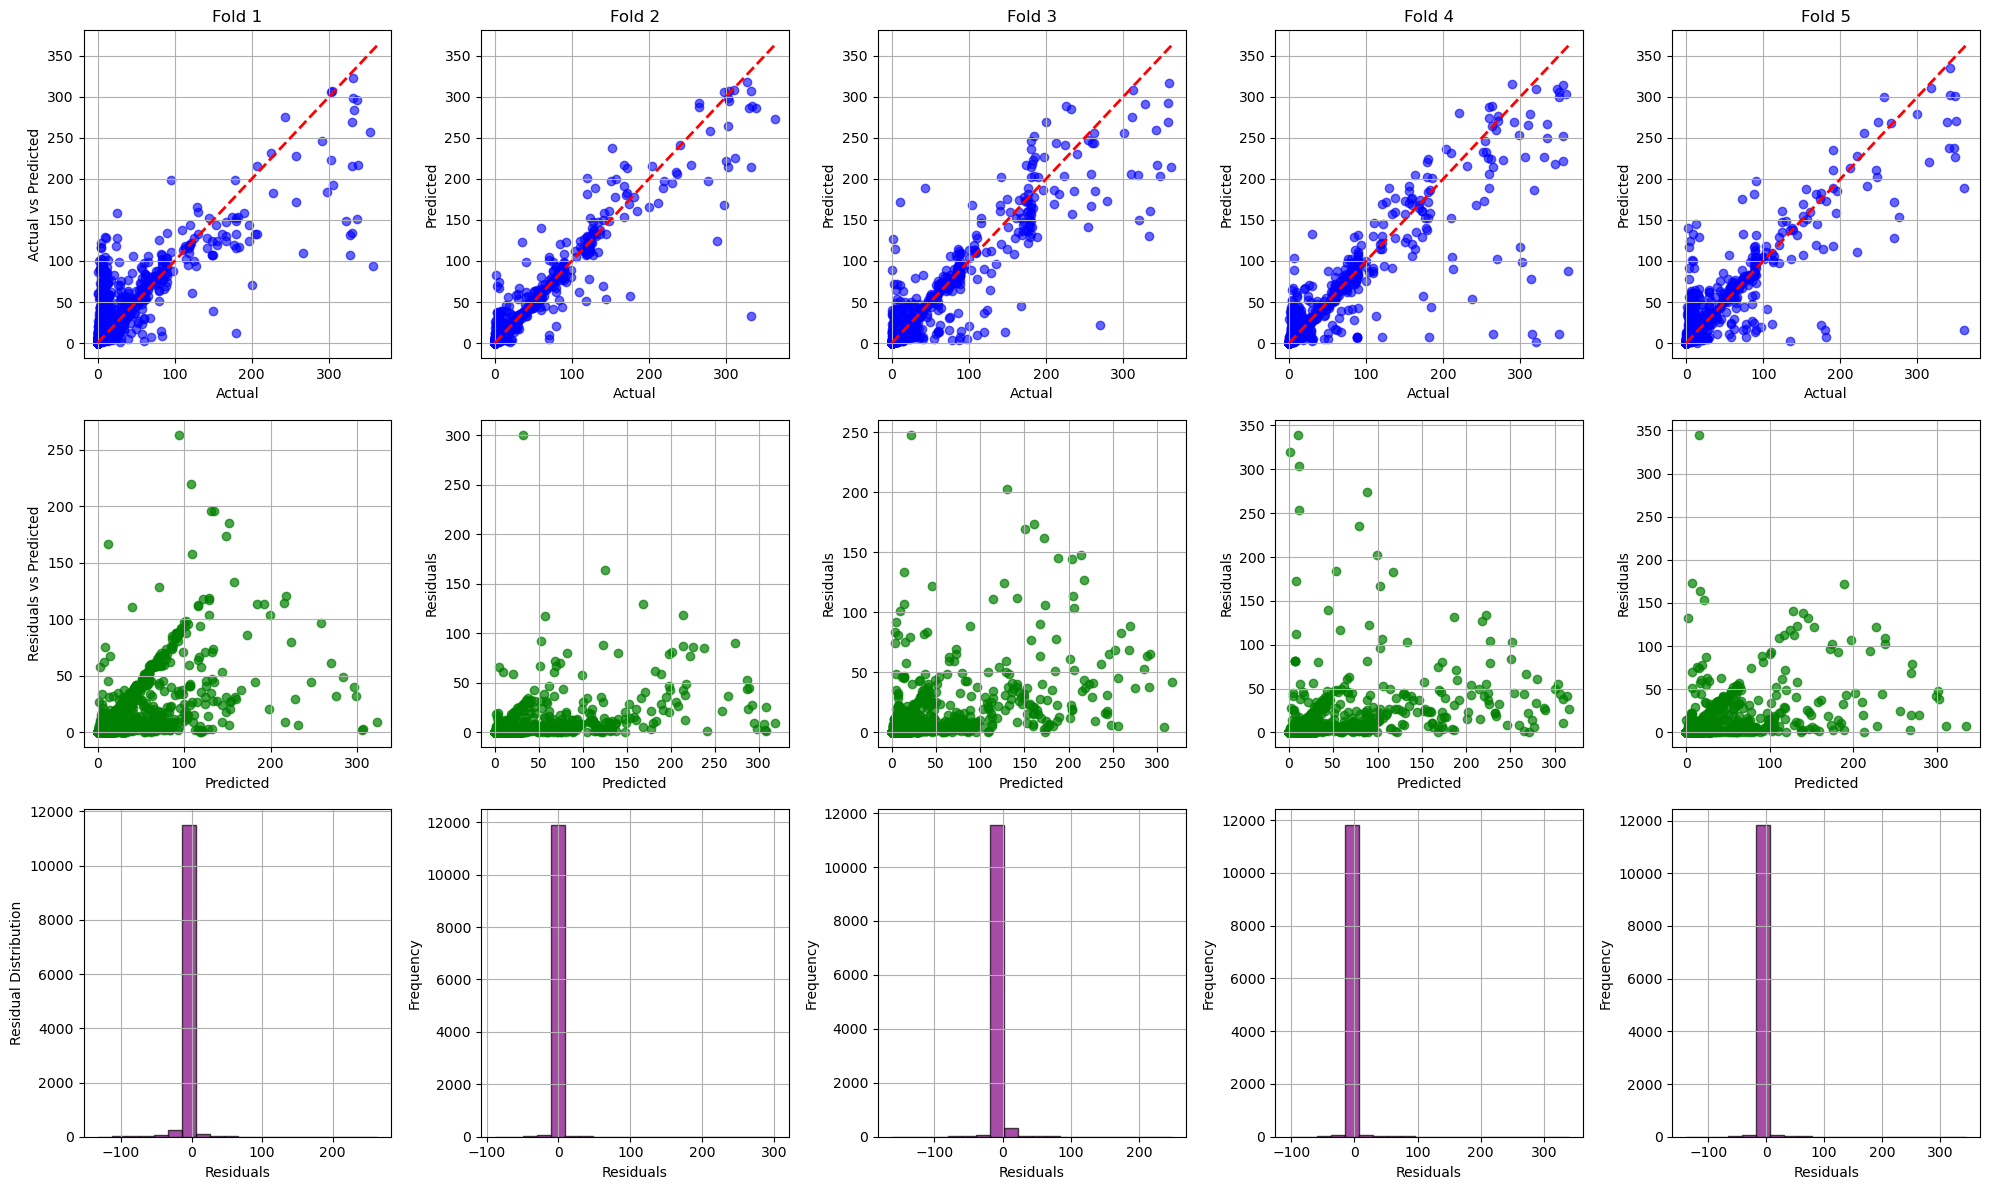

In [10]:
name = 'Bagging'

X = feature_sets['Scaled_Select100Best']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=200), n_estimators=10, random_state=42, n_jobs=16)
    model.fit(X_train, y_reg_train)

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()


## AdaBoost

In [25]:
# name = 'AdaBoost'

# feature_sets = {
#     'Original': X_orig,
#     'PCA_50': X_pca_50,
#     # 'PCA_100': X_pca_100,
#     # 'PCA_200': X_pca_200,
#     'Select50Best': X_selected_50,
#     # 'Select100Best': X_selected_100,
#     # 'Select200Best': X_selected_200,
#     'Scaled_Original': StandardScaler().fit_transform(X_orig),
#     'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
#     # 'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
#     # 'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
#     'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
#     # 'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
#     # 'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
# }

# # Dictionary to store results for all feature sets
# results = {}

# for feature_name, X in feature_sets.items():
#     # Lists to store metrics and weights (test set sizes)
#     mse_scores = []
#     mae_scores = []
#     r2_scores = []
#     weights = []

#     for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
#         base_model = DecisionTreeRegressor(max_depth=200)
#         # base_model = LinearRegression()
#         model = AdaBoostRegressor(estimator=base_model, n_estimators=10, random_state=42)
#         model.fit(X_train, y_reg_train)

#         # Make predictions and compute metrics
#         y_pred = model.predict(X_test)
#         mse = mean_squared_error(y_reg_test, y_pred)
#         mae = mean_absolute_error(y_reg_test, y_pred)
#         r2 = r2_score(y_reg_test, y_pred)
        
#         # Store metrics and weight (number of samples in test set)
#         mse_scores.append(mse)
#         mae_scores.append(mae)
#         r2_scores.append(r2)
#         weights.append(len(train_idx))
        
#         # Print per-fold results
#         # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
#     # Compute weighted averages
#     weighted_mse = np.average(mse_scores, weights=weights)
#     weighted_mae = np.average(mae_scores, weights=weights)
#     weighted_r2 = np.average(r2_scores, weights=weights)
    
#     # Compute simple averages
#     avg_mse = np.average(mse_scores)
#     avg_mae = np.average(mae_scores)
#     avg_r2 = np.average(r2_scores)
    
#     # Store results for this feature set
#     results[feature_name] = {
#         'fold_metrics': [
#             {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
#             for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
#         ],
#         'weighted_averages': {
#             'mse': float(weighted_mse),
#             'mae': float(weighted_mae),
#             'r2': float(weighted_r2)
#         },
#         'simple_averages': {
#             'mse': float(avg_mse),
#             'mae': float(avg_mae),
#             'r2': float(avg_r2)
#         }
#     }
    
#     # Print weighted average results
#     print(f'\nWeighted Average Performance Across 5 Folds:')
#     print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
#     # Print simple average results
#     print(f'Average Performance Across 5 Folds:')
#     print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# # Save results to JSON file
# with open(f'results/reg_aug/{name}_results.json', 'w') as f:
#     json.dump({
#         'model_name': name,
#         'feature_sets': results
#     }, f, indent=4)

# print("Results and model parameters have been saved to 'linear_regression_results.json'")

## Gradient Boost

In [26]:
# name = 'Gradient Boost'

# feature_sets = {
#     'Original': X_orig,
#     'PCA_50': X_pca_50,
#     # 'PCA_100': X_pca_100,
#     # 'PCA_200': X_pca_200,
#     'Select50Best': X_selected_50,
#     # 'Select100Best': X_selected_100,
#     # 'Select200Best': X_selected_200,
#     'Scaled_Original': StandardScaler().fit_transform(X_orig),
#     'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
#     # 'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
#     # 'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
#     'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
#     # 'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
#     # 'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
# }

# # Dictionary to store results for all feature sets
# results = {}

# for feature_name, X in feature_sets.items():
#     # Lists to store metrics and weights (test set sizes)
#     mse_scores = []
#     mae_scores = []
#     r2_scores = []
#     weights = []

#     for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
#         model = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=42)
#         model.fit(X_train, y_reg_train)

#         # Make predictions and compute metrics
#         y_pred = model.predict(X_test)
#         mse = mean_squared_error(y_reg_test, y_pred)
#         mae = mean_absolute_error(y_reg_test, y_pred)
#         r2 = r2_score(y_reg_test, y_pred)
        
#         # Store metrics and weight (number of samples in test set)
#         mse_scores.append(mse)
#         mae_scores.append(mae)
#         r2_scores.append(r2)
#         weights.append(len(train_idx))
        
#         # Print per-fold results
#         # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
#     # Compute weighted averages
#     weighted_mse = np.average(mse_scores, weights=weights)
#     weighted_mae = np.average(mae_scores, weights=weights)
#     weighted_r2 = np.average(r2_scores, weights=weights)
    
#     # Compute simple averages
#     avg_mse = np.average(mse_scores)
#     avg_mae = np.average(mae_scores)
#     avg_r2 = np.average(r2_scores)
    
#     # Store results for this feature set
#     results[feature_name] = {
#         'fold_metrics': [
#             {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
#             for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
#         ],
#         'weighted_averages': {
#             'mse': float(weighted_mse),
#             'mae': float(weighted_mae),
#             'r2': float(weighted_r2)
#         },
#         'simple_averages': {
#             'mse': float(avg_mse),
#             'mae': float(avg_mae),
#             'r2': float(avg_r2)
#         }
#     }
    
#     # Print weighted average results
#     print(f'\nWeighted Average Performance Across 5 Folds:')
#     print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
#     # Print simple average results
#     print(f'Average Performance Across 5 Folds:')
#     print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# # Save results to JSON file
# with open(f'results/reg_aug/{name}_results.json', 'w') as f:
#     json.dump({
#         'model_name': name,
#         'feature_sets': results
#     }, f, indent=4)

# print("Results and model parameters have been saved to 'linear_regression_results.json'")

## Stack

Stack - Fold 0  - MSE: 217.9514, MAE: 4.2460, R2: 0.3796
Stack - Fold 1  - MSE: 72.1310, MAE: 1.7045, R2: 0.8051
Stack - Fold 2  - MSE: 119.1457, MAE: 2.4797, R2: 0.7468
Stack - Fold 3  - MSE: 132.7877, MAE: 2.0222, R2: 0.7518
Stack - Fold 4  - MSE: 115.8130, MAE: 1.9039, R2: 0.6412


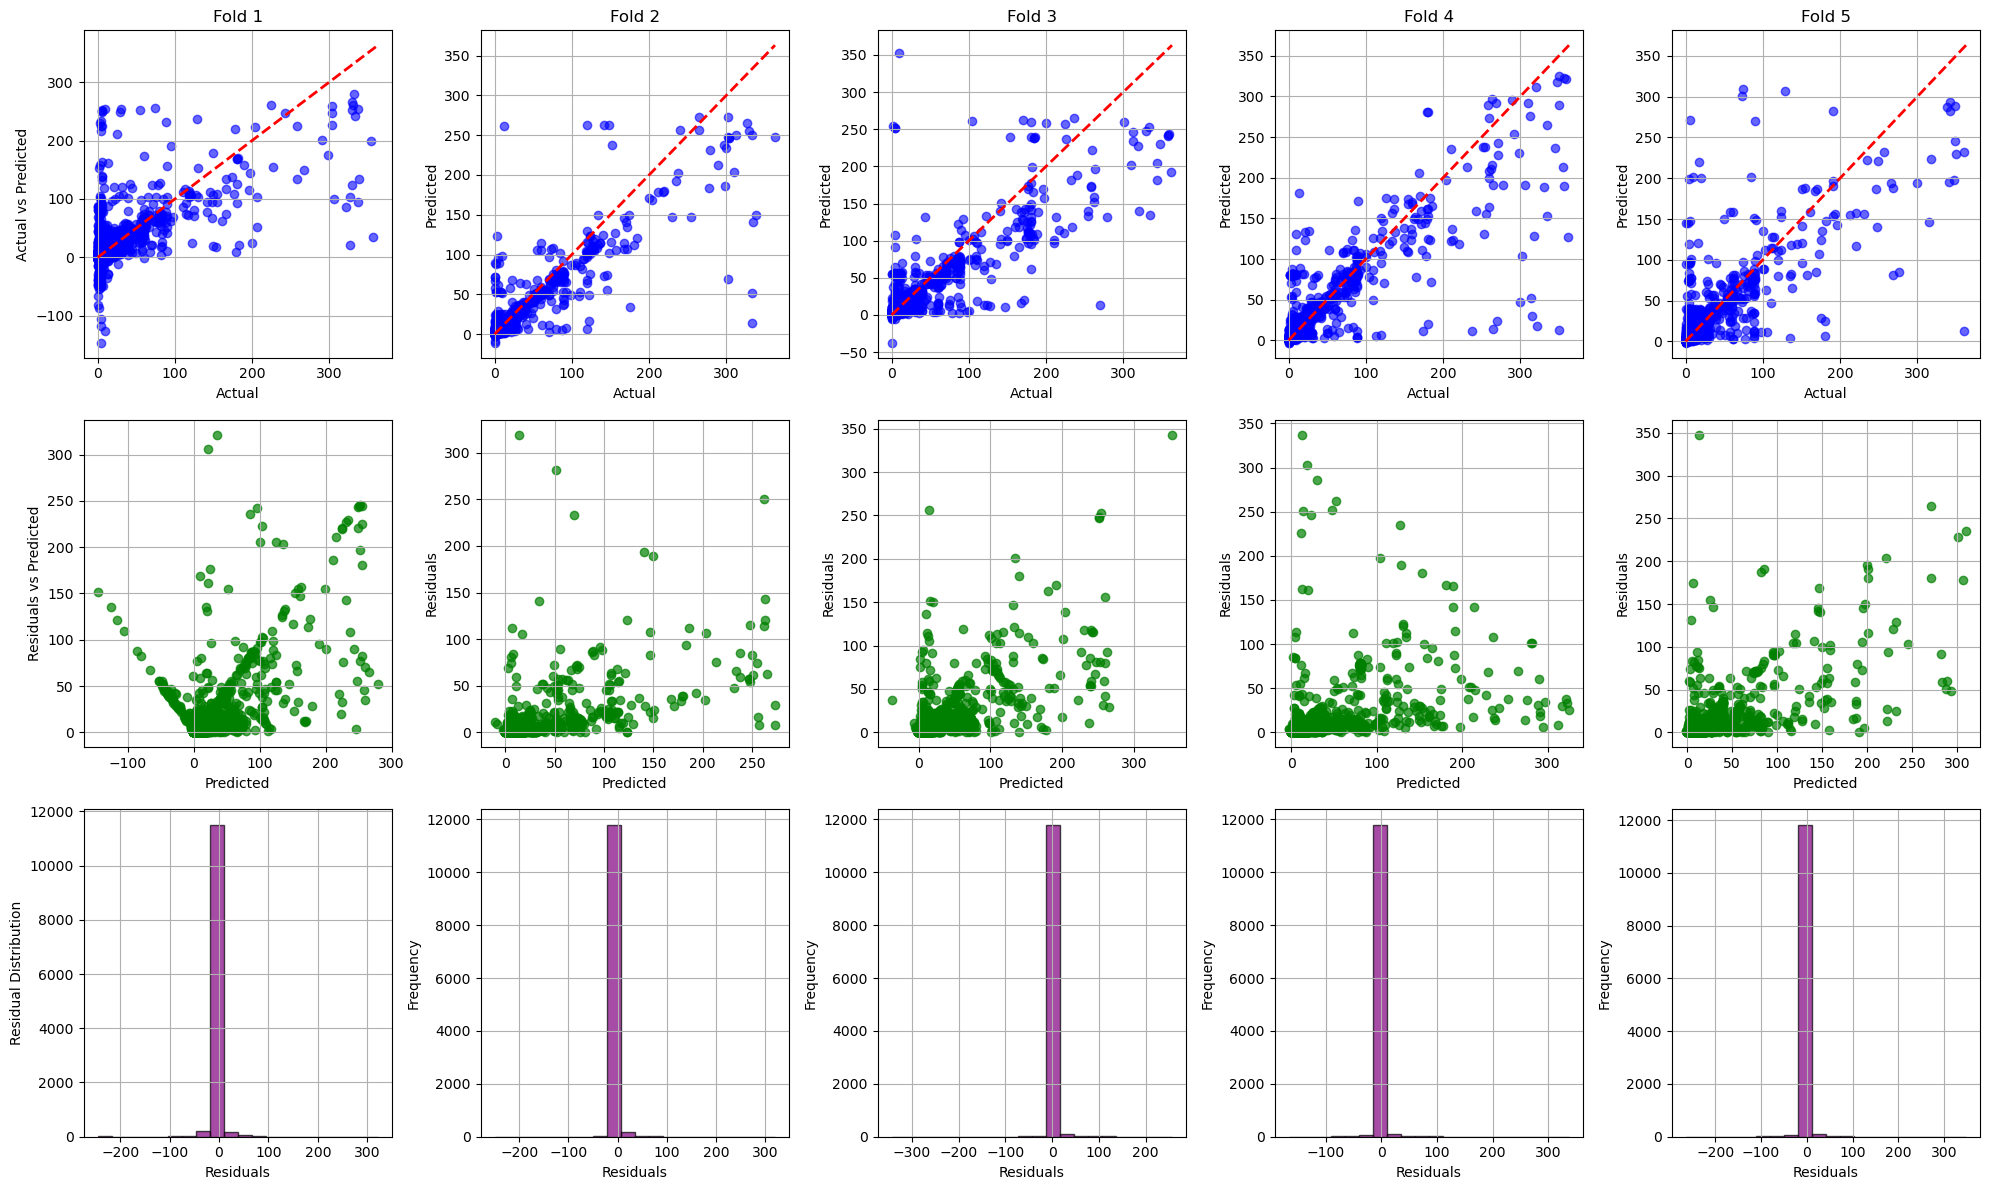

In [11]:
name = 'Stack'

X = feature_sets['Original']

results = []

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]

    base_models = [
                ('lr', LinearRegression()),
                ('dt', DecisionTreeRegressor(max_depth=200))
                ]
    final_model = LinearRegression()
    model = StackingRegressor(estimators=base_models, final_estimator=final_model, n_jobs=16)
    model.fit(X_train, y_reg_train)

    # Make predictions and compute metrics
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    r2 = r2_score(y_reg_test, y_pred)

    results.append(f"{name} - Fold {fold}  - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # 可视化
    for row, row_title in enumerate(row_titles):
        ax = axes[row, fold]
        visualization_subplot(ax, y_pred, y_reg_test, row_title)
        if fold == 0:
            ax.set_ylabel(row_title)
        if row == 0:
            ax.set_title(f"Fold {fold + 1}")

for res in results:
    print(res)

plt.tight_layout()
plt.show()